# Board Game Collection Analysis: <br> Judd Jacobs, Adam Bartoszek and Board Game Geek

<img src="./images/boardgamegeek_logo.jpg" width="100" /> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
<img src="./images/adamcon.jpg" width="100" />

This analysis and comparison aims to examine the board game collections of **Judd Jacobs** and **Adam Bartoszek** in relation to an assumed complete dataset sourced from **Board Games Geek (BGG)**. 

**Board Games Geek** is a comprehensive platform that catalogs board games, providing detailed information about a wide range of games, such as:

- **Year of publication**
- **Suggested age range**
- **Type of gameplay**
- And many other attributes...

The goal of this analysis is to provide insights into the two collections, exploring how they align with the broader dataset and identifying potential trends or notable differences.


## Module imports, data paths, data frame creation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

ab_collection_path = "./Collections/AB_Collection.csv"
jj_collection_path = "./Collections//JJ_Collection.csv"
bgg_collection_path = "./Collections//bgg_dataset.csv"
age_mapping_path = "./Collections//AgeRangeMapping.xlsx"

jj_df = pd.read_csv(jj_collection_path, sep=',')
ab_df = pd.read_csv(ab_collection_path, sep=',')
bgg_df = pd.read_csv(bgg_collection_path, sep=';')
age_df = pd.read_excel(age_mapping_path, engine='openpyxl')

## Function Creations

1. **Filter DataFrame**  
   - Filters the dataframe to exclude rows where `itemtype` is equal to 'expansion'. The "not equal" condition (`!=`) was chosen to allow flexibility for future data variations.

2. **Apply Suffix**  
   - Adds a suffix to the dataframe columns, ensuring uniqueness across columns when datasets are joined. This prevents any confusion or conflict in column names.

3. **Choose Age**  
   - Selects an appropriate age range from available datasets. The preference order is as follows:  
     1. **Adam's Dataset (AB)**: Preferred if available, as it's the largest dataset with the desired format.
     2. **Judd's Dataset (JJ)**: Used if Adam's data is blank or NULL.
     3. **Board Game Geek (BGG)**: Used as the last fallback option.
   - This process ensures a consistent and prioritized approach to selecting the most reliable data.

3. **Remove Columns**  
   - Removes columns from exported, personal data from Board Game Geeks.  They are similarly formatted, so creating this hopefully allows others to more easily insert their data if they choose to do so.  

In [2]:
def filter_dataframe(df):
    # Remove expansions from the list since they are add-ons to an existing game, not a new game itself
    filtered_df = df[df['itemtype'] != 'expansion']
    return filtered_df

def apply_suffix(df, suffix):
    # add suffix to all columns in DF to support easier separation and analysis
    return df.add_suffix(suffix)

def choose_age(row):
    # Check the values in my preferred order--chosen b/c I preferred the representation in the person collections
    # I started with Adam's b/c his was largest of those two.
    for col in ['bggrecagerange_ab', 'bggrecagerange_jj', 'Min Age']:
        if pd.notnull(row[col]):
            return row[col]
    return None  # Return None if all are NaN/NULL

def remove_columns(df, columns_to_remove):
   # Removes specified columns from the input DataFrame.
    return df.drop(columns=columns_to_remove)

# List of columns to remove
columns_to_remove = [
    'rating', 'numplays', 'weight', 'fortrade', 'want', 'wanttobuy', 'wanttoplay',
    'prevowned', 'preordered', 'wishlist', 'wishlistpriority', 'wishlistcomment', 'comment',
    'conditiontext', 'haspartslist', 'wantpartslist', 'collid', 'baverage', 'average', 'avgweight',
    'rank', 'numowned', 'objecttype', 'originalname', 'bggbestplayers', 'bgglanguagedependence',
    'publisherid', 'imageid', 'language', 'other', 'barcode', 'version_publishers', 'version_languages',
    'version_yearpublished', 'version_nickname', 'objectname', 'minplayers', 'maxplayers', 'playingtime',
    'maxplaytime', 'minplaytime', 'yearpublished', 'bggrecplayers','year'
]

## Data Manipulation and Merging

### Applying Functions to DataFrames and Joining Datasets

1. **Remove Unnecessary Columns**  
   - Apply function to remove unnecessary columns from personal datasets.

2. **Filter Datasets**  
   - Removed expansions from personal datasets since this does not represent a new game.

3. **Apply Suffixes**  
   - Added suffixes to personal datasets to help ensure ease of analysis by making data distinctions obvious.

4. **Combined Object ID Column**  
   - Created a **"combined"** column for the `objectid` in the two personal datasets, making it easier to join with the larger **Board Game Geeks** dataset.

5. **Age Range Filtering and Distribution**  
   - Generated a **"combined"** column specifically for age range filtering, allowing for more efficient distribution analysis across datasets.

6. **Merging Mapping File**  
   - Merged a **mapping file** with the age related data to enhance **visualization** and **aggregation**, providing more meaningful insights.


In [3]:
jj_df = remove_columns(jj_df, columns_to_remove)
ab_df = remove_columns(ab_df, columns_to_remove)
bgg_df = bgg_df.drop(['Users Rated', 'Rating Average', 'BGG Rank', 'Complexity Average', 'Owned Users', 'Mechanics'], axis=1)

#print(jj_df.columns)
#print(ab_df.columns)

jj_df_filtered = filter_dataframe(jj_df)
ab_df_filtered = filter_dataframe(ab_df)

jj_df_suffixed = apply_suffix(jj_df_filtered, '_jj')
ab_df_suffixed = apply_suffix(ab_df_filtered, '_ab')

# Merge AB & JJ as outer first, added a new column to collect objectid as one combined column, similar for ageranges
ab_jj_outer = pd.merge(jj_df_suffixed, ab_df_suffixed, left_on='objectid_jj', right_on='objectid_ab', how='outer')
ab_jj_outer['objectid_comb'] = ab_jj_outer['objectid_ab'].combine_first(ab_jj_outer['objectid_jj'])
ab_jj_outer['bggrecagerange_comb'] = ab_jj_outer['bggrecagerange_ab'].combine_first(ab_jj_outer['bggrecagerange_jj'])

# Merge joined AB&JJ data to largest BGG dataset
result = pd.merge(bgg_df, ab_jj_outer, left_on='ID', right_on='objectid_comb', how='left')

# create new column to capture and combine all age ranges from all 3 datasets based on most preferred to least as outlined in above function
result['age_comb'] = result.apply(choose_age, axis=1)

# merge age range mapping for cleaner representation and aggregation
result = pd.merge(result, age_df, left_on='age_comb', right_on='bggrecagerange', how='left')

#print(jj_df_suffixed.columns)
#print(ab_df_suffixed.columns)
#print(ab_jj_outer.columns)
#print(list(result.columns))
#row_count = result.count().max()
#print(f"Number of rows: {row_count}")

## Beginning the Analysis

1. **Total Counts for Adam, Judd, and BGG**  
   - Calculate and compare the total counts for **Adam**, **Judd**, and **BGG** as percentages.

2. **Creating Age Range Charts**  
   - Generate charts for each dataset, broken out by **age ranges** to visually compare the data.
   -  **Note:** The **age range** data was inconsistent and overly segmented, making it difficult to perform a solid analysis.
   - To resolve this, a **mapping document** was created to standardize the age ranges, enabling easier aggregation. This mapping is applied in the analysis below.

3. **Creating Charts by Domain**
   - Generate charts to represent various types of games (domains) with counts and percentages of the total for each collection.
   - 'Unspecified' was used where no domain was provided in the dataset.  Another chart was created with that removed to better see scale regarding the items that were properly recorded.




Out of the total 20327 games listed on Board Games Geek, Adam has 1757 or 8.64% and Judd has 298 or 1.47%




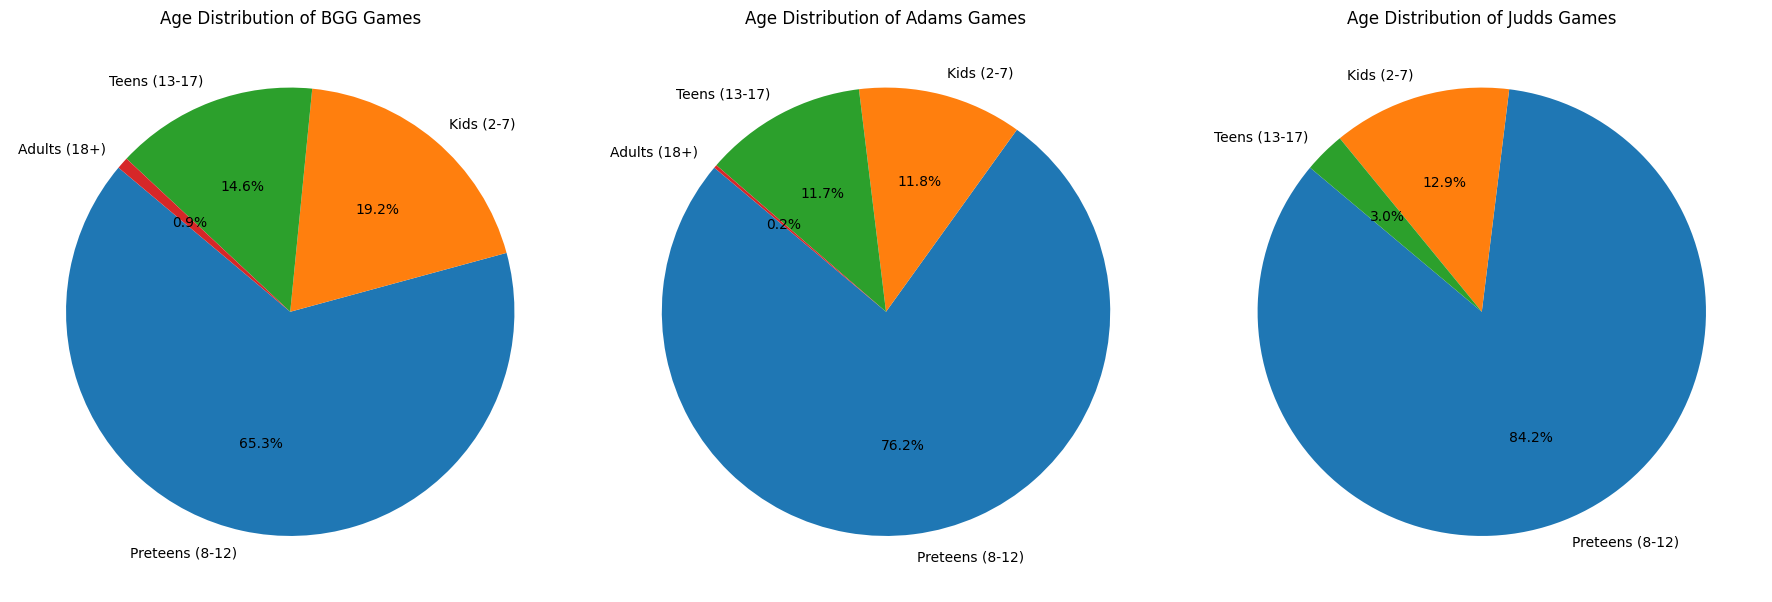

In [4]:
#Analysis of Age Distribution
# Step 1: Count distinct values in 'ID' column
distinct_id_count = result['ID'].nunique()

# Step 2: Count distinct, non-NaN values in 'objectid_ab' column
dist_objectid_ab = result[result['itemtype_ab'] != 'expansion']['objectid_ab'].dropna().loc[result['objectid_ab'] != ''].nunique()
dist_objectid_jj = result[result['itemtype_jj'] != 'expansion']['objectid_jj'].dropna().loc[result['objectid_jj'] != ''].nunique()
#print(distinct_id_count)
#print(dist_objectid_ab)
#print(dist_objectid_jj)

# Step 3: Calculate the percentage
ab_totalperc = round((dist_objectid_ab / distinct_id_count) * 100, 2)
jj_totalperc = round((dist_objectid_jj / distinct_id_count) * 100, 2)

bgg_age_counts = result['AggregateMapping'].value_counts()
ab_age_counts = result[result['objectid_ab'].notna()]['AggregateMapping'].value_counts()
jj_age_counts = result[result['objectid_jj'].notna()]['AggregateMapping'].value_counts()

# Print the result
print(f"\n\nOut of the total {distinct_id_count} games listed on Board Games Geek, Adam has {dist_objectid_ab} or {ab_totalperc}% and Judd has {dist_objectid_jj} or {jj_totalperc}%\n\n") 

# Output the result dataframe to an Excel file
#result.to_excel('result.xlsx', index=False)
#ab_jj_outer.to_excel('ab_jj_outer.xlsx', index=False)

# Create a figure with 1 row and 3 columns (for 3 pie charts)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjust size as needed

# Pie chart for BGG
axes[0].pie(bgg_age_counts, labels=bgg_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Age Distribution of BGG Games')

# Pie chart for AB
axes[1].pie(ab_age_counts, labels=ab_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Age Distribution of Adam''s Games')

# Pie chart for JJ
axes[2].pie(jj_age_counts, labels=jj_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Age Distribution of Judd''s Games')

# Display the pie charts
plt.tight_layout()  # Automatically adjusts the layout to prevent overlap
plt.show()



## Further analysis by 'Domains' (type of game)

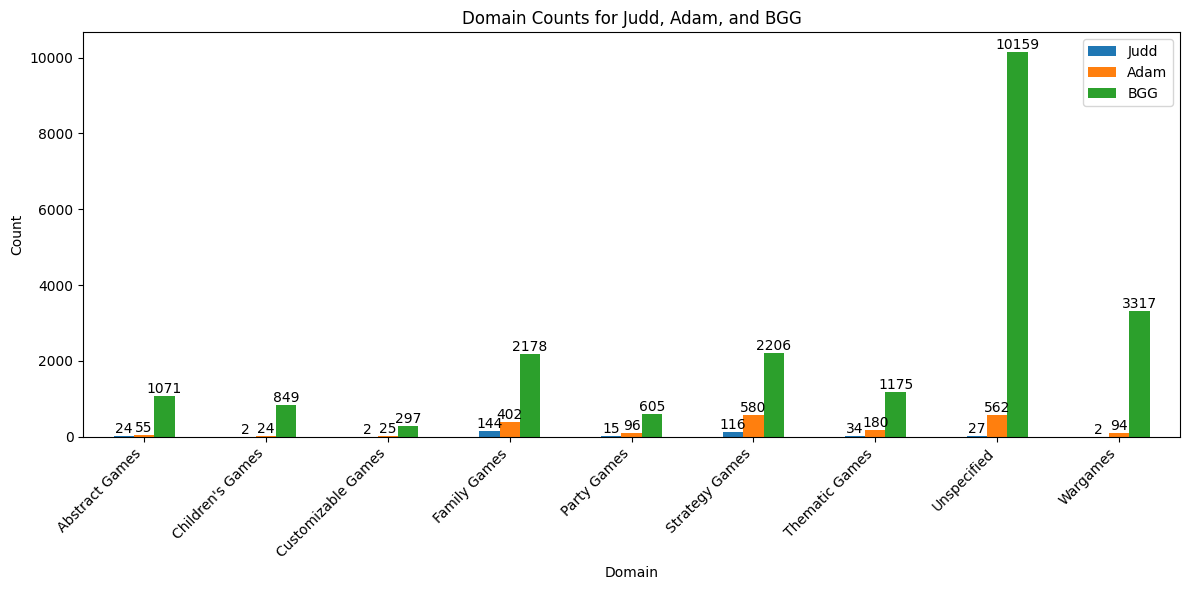

In [5]:
# Further analysis by 'Domains' (type of game)
# Step 1: Split 'Domains' into separate rows and handle spaces and empty values
result['Domains'] = result['Domains'].fillna('').astype(str)
result['Domains'] = result['Domains'].str.split(',').apply(lambda x: [item.strip() if item.strip() != '' else 'Unspecified' for item in x])

result_split = result.explode('Domains')

# Step 2: Initialize columns for JJ, AB, and BGG counts
result_split['Judd'] = 0
result_split['Adam'] = 0
result_split['BGG'] = 0

# Step 3: Update counts based on the conditions
# Update JJ count for rows where own_jj == 1
result_split.loc[result_split['own_jj'] == 1, 'Judd'] = 1

# Update AB count for rows where own_ab == 1
result_split.loc[result_split['own_ab'] == 1, 'Adam'] = 1

# Update BGG count for all rows (since it's simply a presence count)
result_split['BGG'] = 1

#result.to_excel('result_split.xlsx', index=False)
#print(result_split.head)

# Step 4: Group by 'Domains' and sum the counts to avoid duplication
aggregated_data = result_split.groupby('Domains')[['Judd', 'Adam', 'BGG']].sum()

# Step 5: Plot the bar graph (value labels)
ax = aggregated_data.plot(kind='bar', figsize=(12, 6))

# Customize the plot
plt.title('Domain Counts for Judd, Adam, and BGG')
plt.ylabel('Count')
plt.xlabel('Domain')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent overlap

ax.bar_label(ax.containers[0])  # This will add labels for the first container (Judd column)
ax.bar_label(ax.containers[1])  # This will add labels for the second container (Adam column)
ax.bar_label(ax.containers[2])  # This will add labels for the third container (BGG column)

# Show the plot
plt.show()


## Adjust the plot to remove 'Unspecified' to better see the scale for the populated data

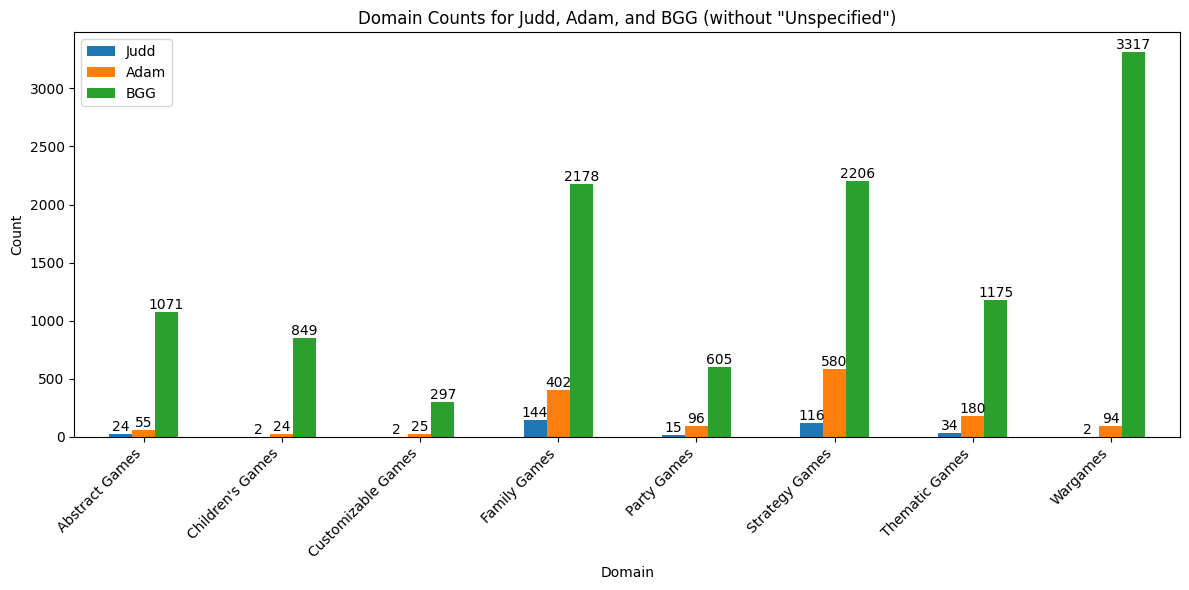

In [ ]:
# Adjust the plot to remove 'Unspecified' to better see the scale for the populated data

# Step 1: Filter out "Unspecified" domains for the second plot
result_split_no_unspecified = result_split[result_split['Domains'] != 'Unspecified']

# Step 2: Group by 'Domains' and sum the counts...again
aggregated_data_no_unspecified = result_split_no_unspecified.groupby('Domains')[['Judd', 'Adam', 'BGG']].sum()

# Step 3: Plot the second bar graph
ax = aggregated_data_no_unspecified.plot(kind='bar', figsize=(12, 6))

# Customize the plot
plt.title('Domain Counts for Judd, Adam, and BGG (without "Unspecified")')
plt.ylabel('Count')
plt.xlabel('Domain')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent overlap

ax.bar_label(ax.containers[0])  # This will add labels for the first container (Judd column)
ax.bar_label(ax.containers[1])  # This will add labels for the second container (Adam column)
ax.bar_label(ax.containers[2])  # This will add labels for the third container (BGG column)

# Show the plot
plt.show()

## Chart with Domains listed as Percentage of Whole collection

- This chart was filtered to focus on the vast majority of game titles that were under 3000 minutes of estimated gameplay and the odd '0' minutes.  There were only a few above 3000 minutes and it can be assumed that 0 minutes is an error.  None of these titles were in Adam's or Judd's collection and keeping those skewed the scale of the chart drmatically, making it difficult to visually review.

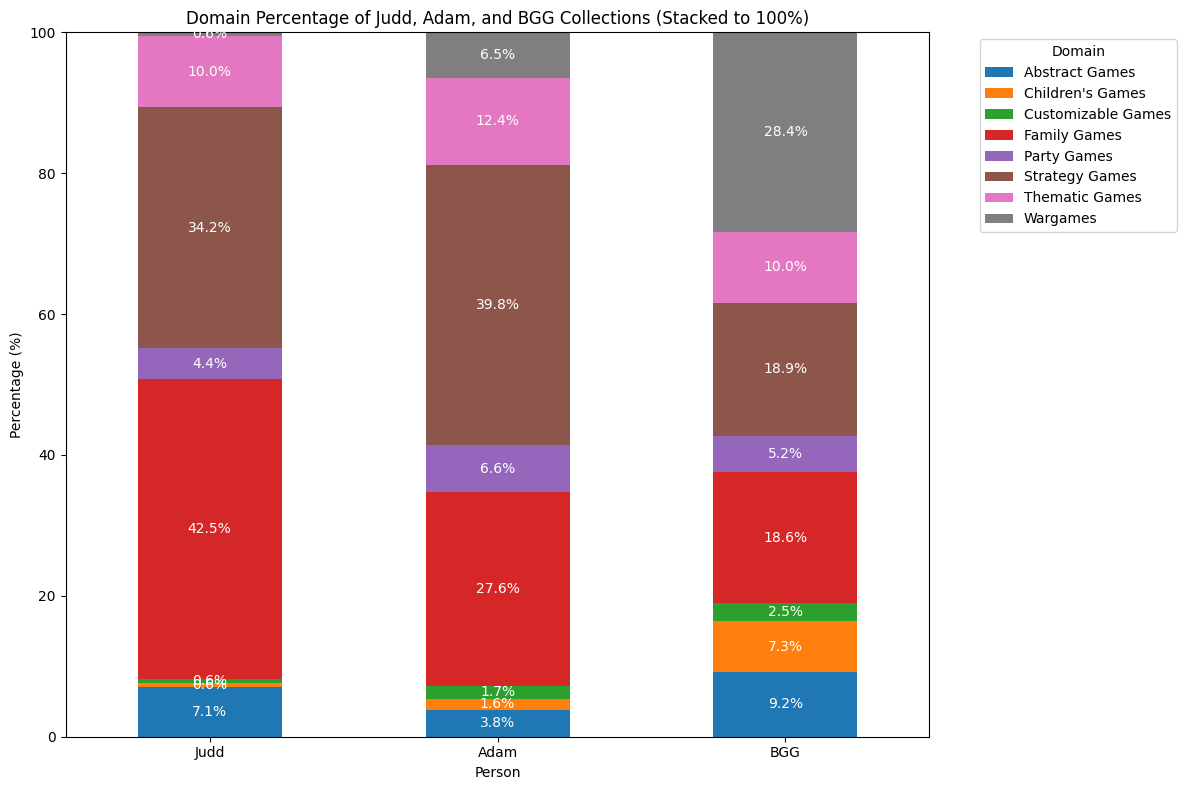

In [7]:
# Step 1: Filter out "Unspecified" domains
result_split_no_unspecified = result_split[result_split['Domains'] != 'Unspecified']

# Step 2: Group by 'Domains' and sum the counts
aggregated_data_no_unspecified = result_split_no_unspecified.groupby('Domains')[['Judd', 'Adam', 'BGG']].sum()

# Step 3: Calculate percentages
percentage_data = aggregated_data_no_unspecified.div(aggregated_data_no_unspecified.sum(axis=0)) * 100

# Step 4: Plot the stacked bar chart
ax = percentage_data.transpose().plot(kind='bar', stacked=True, figsize=(12, 8))

# Add percentage labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                f'{height:.1f}%', ha='center', va='center', color='white', fontsize=10)

# Customize the plot
plt.title('Domain Percentage of Judd, Adam, and BGG Collections (Stacked to 100%)')
plt.ylabel('Percentage (%)')
plt.xlabel('Person')
plt.legend(title='Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()





## Scatter Chart with Playtime vs. Minimum Number of Players

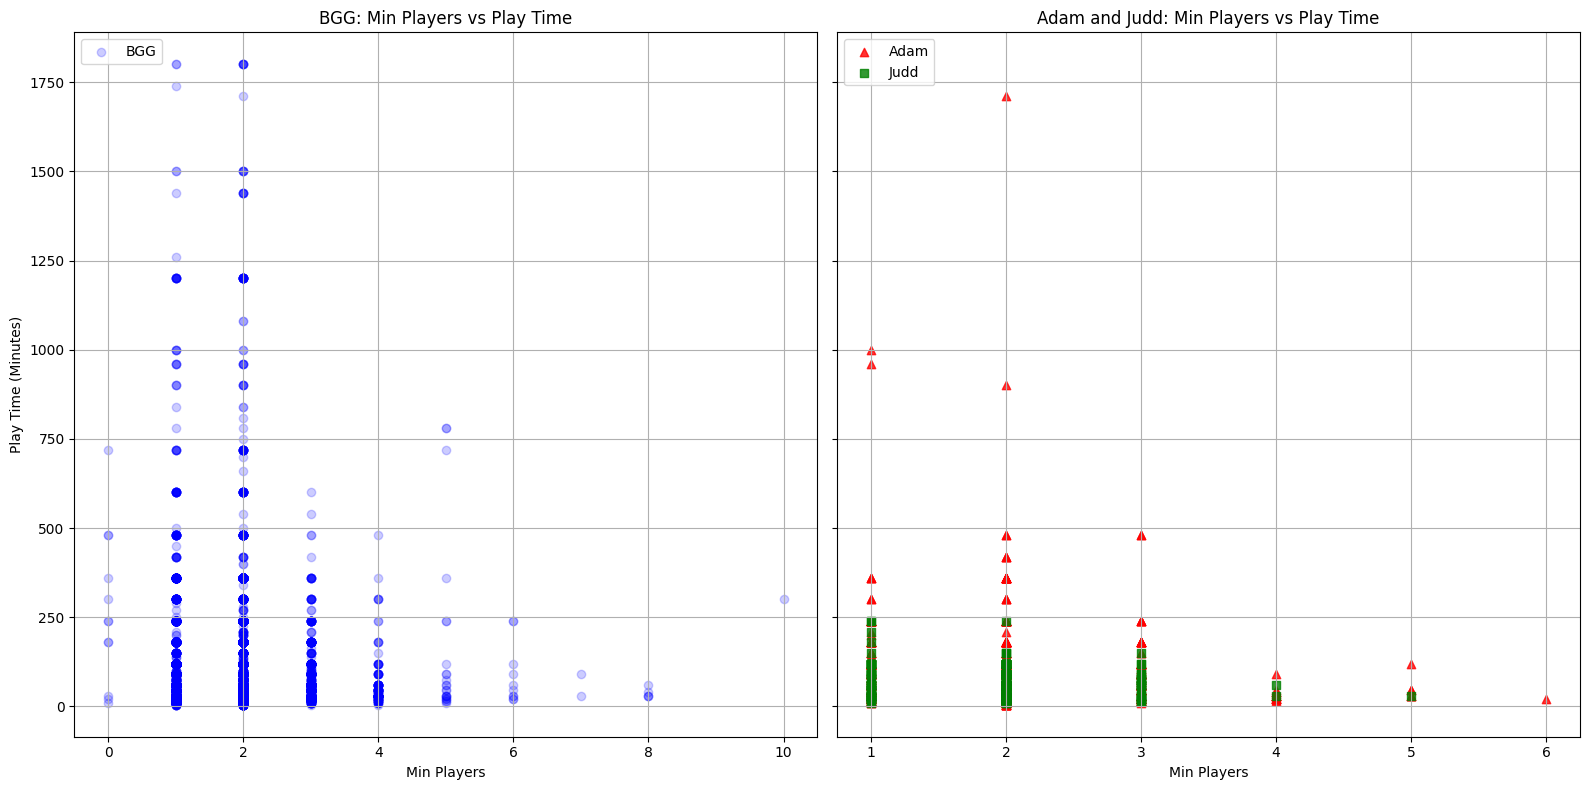

In [ ]:
# Filter data where Play Time is between 5 and 6000 minutes
filtered_data = result_split_no_unspecified[
    (result_split_no_unspecified['Play Time'] >= 5) & 
    (result_split_no_unspecified['Play Time'] <= 2000)
]

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot BGG data
axes[0].scatter(filtered_data['Min Players'],
                 filtered_data['Play Time'],
                 color='blue', marker='o', alpha=0.2, label='BGG')
axes[0].set_title('BGG: Min Players vs Play Time')
axes[0].set_xlabel('Min Players')
axes[0].set_ylabel('Play Time (Minutes)')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot Adam and Judd data (separated out b/c all 3 together was too 'busy')
axes[1].scatter(filtered_data['Min Players'][filtered_data['own_ab'] == 1],
                 filtered_data['Play Time'][filtered_data['own_ab'] == 1],
                 color='red', marker='^', alpha=0.8, label='Adam')

axes[1].scatter(filtered_data['Min Players'][filtered_data['own_jj'] == 1],
                 filtered_data['Play Time'][filtered_data['own_jj'] == 1],
                 color='green', marker='s', alpha=0.8, label='Judd')

axes[1].set_title('Adam and Judd: Min Players vs Play Time')
axes[1].set_xlabel('Min Players')
axes[1].legend(loc='upper left')
axes[1].grid(True)

# show the plot
plt.tight_layout()
plt.show()


## Conclusions
### 🎲 **Age Range Comparison: Adam Bartoszek's Collection vs. BoardGameGeek**

When comparing Adam and Judd's collections to the broader selection on BoardGameGeek (BGG), a few trends stand out:  

#### 🔎 **1. Similar Trend in Age Distribution**
- Both Adam's and Judd's collection have the lion's share of the titles fall into the Preteens category, representing ages 8-12. As a percentage of their collection , this is also represents a 10% increase or more of the baseline for BGG.
- Kids games (ages 2-7) represent the next largest group for all three.  This is surprising for two reasons:
    - It was expected that kids games were a much smaller representation of the overall market.
    - The percentage of kids titles were much larger in Adam's and Judd's collection than expected.

#### 🧑‍🤝‍🧑 **2. Emphasis Strategy and Family Games**
- Adam collects a significant number of strategy titles, representing the largest portion of his collection (~40%) followed by family games at (~28%). This mimics a similar, but reversed focus on Judd's collection.  
- On BGG, these categories are far less represented, each coming in under 20%.  
- As both Adam and Judd are self-professed "hobbyists" this is unusual because both have very little wargames titles (known for deep strategy elements).  

#### 🧸 **3. Limited Interest in Children's Games**
- Family-friendly and younger audience games are noticeably light in both Judd's and Adam's collection.  
- While, as a whole, children's titles represent just over 7% of board games, there is virtually no representation in Adam or Judd's collection.  Further emphasizing focus on more adult and stratetgy oriented games.  

---

#### 📌 **Overall Takeaway**  
Adam's collection is primarily tailored toward mature, strategic gameplay experiences, with a particular emphasis on games suitable for adults and teenagers. Compared to the more balanced distribution on BGG, his selection has fewer light, family-friendly games — a reflection of a serious hobbyist with a passion for immersive, challenging titles.  

Judd's collection is primarily tailored toward family and strategy games, perhaps indicating a focus on inclusion for all kinds of players (especially children or young persons).  This can also be indicated by obvious lack of wargame titles and customizable games which could be difficult to play and understand for younger players.

In regards to the games as a whole, it seems that playtime and the minimum number of players are tied unexpectedly.  Initially I thought that the more players involved, the longer the game should take since that might introduce complexity, decision times, etc.  In fact, it seems that the fewer the players, the more likely the game takes longer!  Another version of this in the future can perhaps plot the estimated time of gameplay vs. the domain or type of game to help see what types of games typically shake out!